# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# Импортируем библиотеки.
import pandas as pd
import matplotlib.pyplot as plt
    
pd.set_option('display.max_columns', None)

In [2]:
# Читаем файл.

    
# Выведем первые 5 строк.
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# Выведем основную информацию о датафрейме с помощью метода info().
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

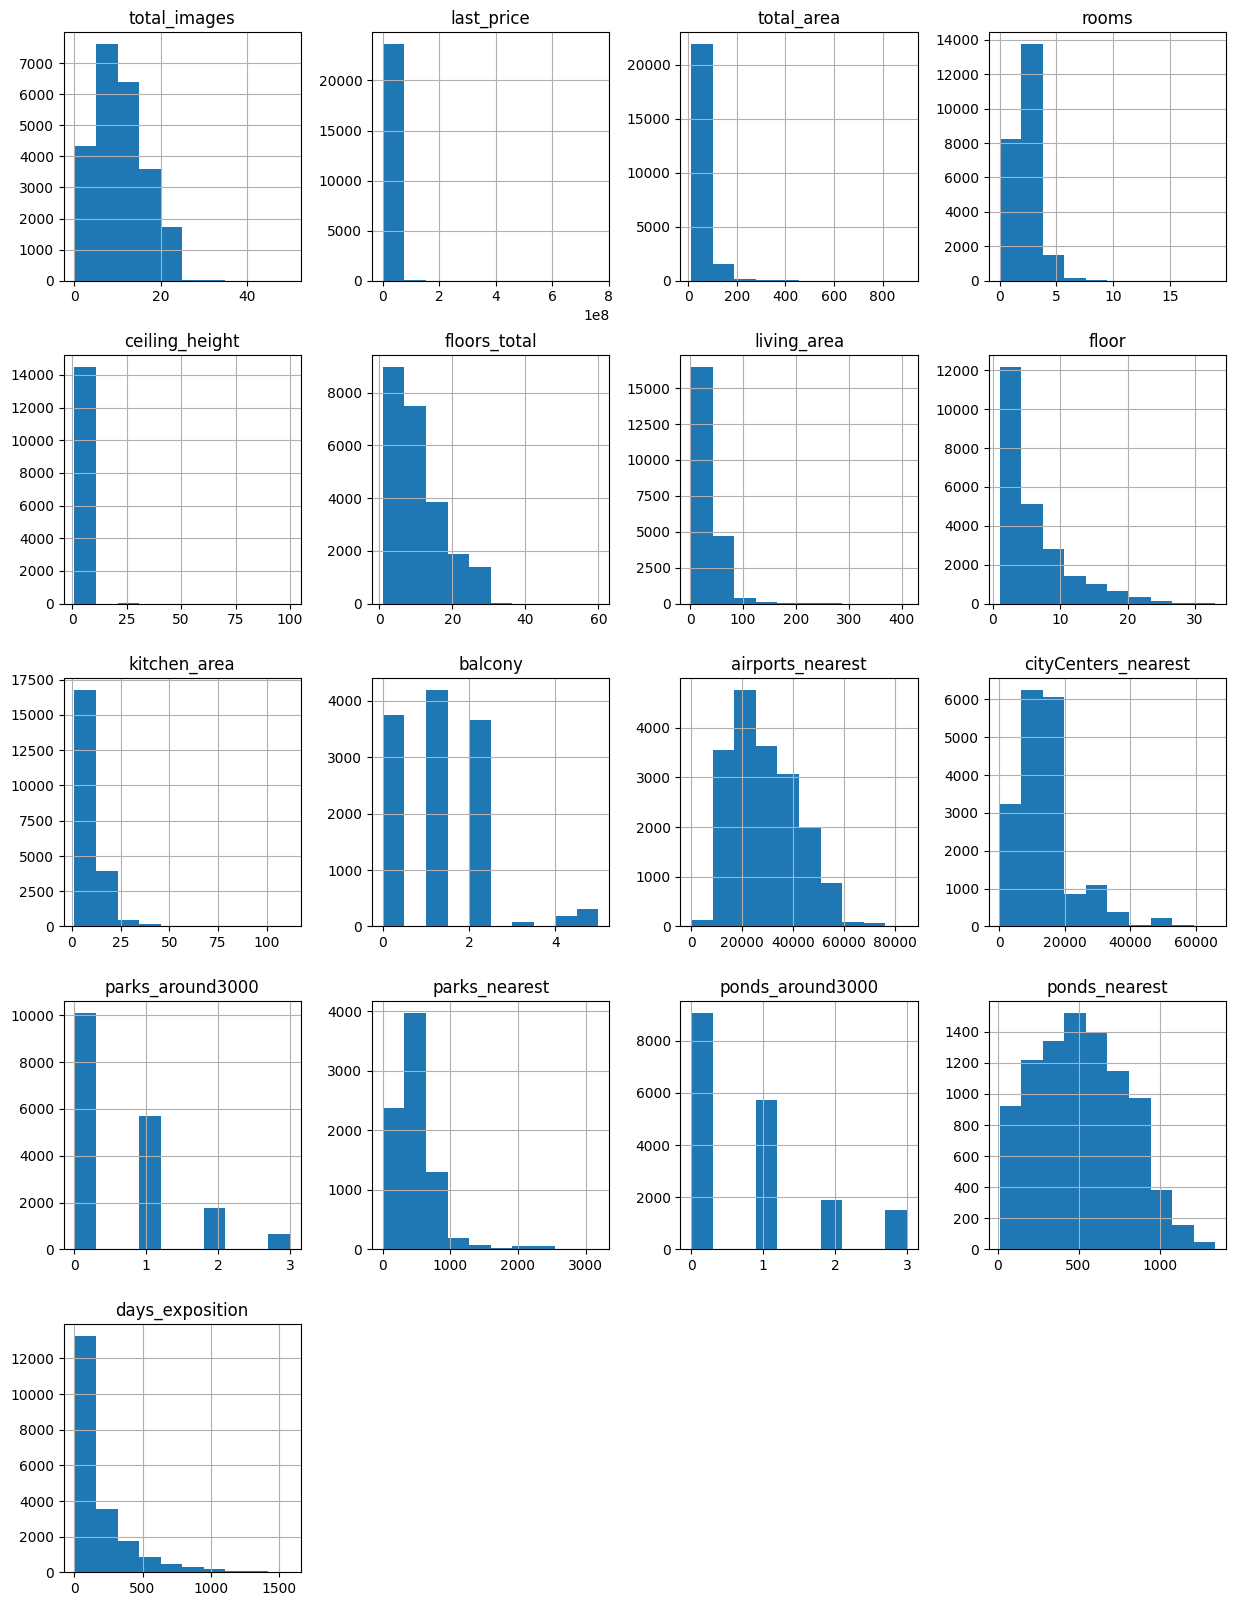

In [4]:
# Построим общую гистограмму для всех числовых столбцов.
data.hist(figsize=(15, 20));

Судя из увиденных данных, необходимо провести предобработку: заполнить пропуски, поменять тип данных, изучить уникальные значения и устранить дубликаты, если они есть, найти и устранить редкие и выбивающиеся значения, если они есть.

### Предобработка данных

In [5]:
# Выведем количество пропущенных значений для каждого столбца, используя комбинацию двух методов.
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

__Что будем делать, судя из увиденных данных:__

      Column              Dtype       None 
    first_day_exposition object          0 - поменяем на тип данных datetime
    last_price           float64         0 - поменяем на тип данных int64, проанализируем min и max значения
    ceiling_height       float64      9195 - поменяем на тип данных int64, пропуски заполним средним значением
    floors_total         float64        86 - поменяем на тип данных int64, пропуски заполним по столбцу floor
    living_area          float64      1903 - достаточно большое количество пропусков, необходим анализ
    is_apartment         object      20924 - много пропусков, предположим, что это не апартаменты и заполним пропуски False
    kitchen_area         float64      2278 - большое количество пропусков, необходим анализ
    balcony              float64     11519 - поменяем на тип данных int64, много пропусков, предположим, что нет балкона 
                                             и заполним пропуски 0
    locality_name        object         49 - пропусков мало, скорее всего не заполнили, на анализ не повлияет, удалим,
                                             а также проверим столбец на дубликаты
    airports_nearest     float64      5542 - много пропусков, оставим как есть, скорее всего рядом нет аэропорта
    cityCenters_nearest  float64      5519 - приведем название столбца к змеиному регистру, много пропусков оставим как
                                             есть, скорее всего находятся далеко от центра
    parks_around3000     float64      5518 - поменяем на тип данных int64, много пропусков, скорее всего парков в районе  
                                             3-х км нет, заполним пропуски 0
    parks_nearest        float64     15620 - много пропусков, оставим как есть, анализу не помешают
    ponds_around3000     float64      5518 - поменяем на тип данных int64, много пропусков, скорее всего водоемов в районе  
                                             3-х км нет, заполним пропуски 0
    ponds_nearest        float64     14589 - много пропусков, оставим как есть, анализу не помешают
    days_exposition      float64      3181 - поменяем на тип данных int64, много пропусков, предположим, что это объявления,
                                             которые до сих пор активны, удалять не будем

In [6]:
# приведем название столбца к змеиному регистру
data.rename(columns = {'cityCenters_nearest':'citycenters_nearest'}, inplace=True)

# переведем дату в формат datetime и уберем время, т.к. оно отсутствует
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

# удалим записи, где отсутствует информация о населенном пункте, 
# т.к. процент пропусков в этом столбце небольшой и на анализ не повлияет
data.dropna(subset=['locality_name'], inplace=True)
data.reset_index(drop= True , inplace= True)   # сбросим индексы

# этажность заполним по столбцу floor, т.к. этажность дома не может быть ниже этажа квартиры,
# и переведем этажность в целочисленный тип данных
data['floors_total'] = data['floors_total'].fillna(data['floor']).astype('int')

# переведем цену в целочисленный тип данных
data['last_price'] = data['last_price'].astype('int')

# заменим пропущенные значения на 0, и переведем количество балконов, парков и водоемов в целочисленный тип данных
data['balcony'] = data['balcony'].fillna(0).astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')

# заменим пропущенные значения апартаментов на False, т.к.скорее всего эти значения не являются апартаментами
data['is_apartment'] = data['is_apartment'].fillna(False)

В столбце количество дней размещения объявления большое количество пропусков. Можно предположить, что это объявления, которые до сих пор активны. Удалять не будем. преобразуем в тип данных `int`.

In [7]:
# Заменим NaN целым числом (например, 0), преобразуем в int, преобразует в object и, повторно вставит NaN.
# Затем преобразуем в int
try:
    data['days_exposition'] = (
    data['days_exposition'].fillna(0)
    .astype(int)
    .astype(object)
    .where(data['days_exposition'].notnull())
) 
    print('Преобразован')
except:
    print('Ошибка преобразования')
    
print()
data['days_exposition'] = data['days_exposition'].astype('Int64')

data[['days_exposition']].info()   # Проверим

Преобразован

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   days_exposition  20470 non-null  Int64
dtypes: Int64(1)
memory usage: 208.0 KB


In [8]:
# Посмотрим уникальные значения населенных пунктов
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Действительно, есть масса повторений, записанных по разному. Чтобы избавиться от дубликатов, приветем все названия к нижнему регитру, заменим слова в названиях населенных пунктов: _"поселок"_ на _"посёлок"_ и далее _"городской посёлок"_ на _"посёлок городского типа"_.  

In [9]:
# Приведем все названия населенных пунктов к нижнему регистру, чтобы избавиться от дубликатов
data['locality_name'] = data['locality_name'].str.lower()

# Создадим функцию, которая поменяет названия всем неявным дубликатам
def replace_locality_name(wrong_values, correct_value): 
    for wrong_value in wrong_values: 
        data['locality_name'] = data['locality_name'].str.replace(wrong_value, correct_value)
        
# Заменим в названиях населенных пунктов "поселок" на "посёлок" и далее "городской посёлок" на "посёлок городского типа" 
# Для этого объявим переменные с данными значениями и применим к нашей функции
duplicates = ['поселок']
correct = 'посёлок'
replace_locality_name(duplicates, correct)

duplicates = ['городской посёлок']
correct = 'посёлок городского типа'
replace_locality_name(duplicates, correct)

data['locality_name'].unique() # Проверим

array(['санкт-петербург', 'посёлок шушары',
       'посёлок городского типа янино-1', 'посёлок парголово',
       'посёлок мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'деревня кудрово', 'коммунар', 'колпино',
       'посёлок городского типа красный бор', 'гатчина',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'посёлок молодцово',
       'посёлок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'посёлок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'посёлок торковичи', 'посёлок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'посёл

In [10]:
# Посмотрим уникальные значения высоты потолков.
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Встречаются аномально высокая и низкая высоты. 
Высота в 1м или 100м не может быть,если это не избушка гномов или замок великанов. 
25м и 32м логично предположить, что это 2.5м и 3.2м.
Скорее всего была допущена ошибка при занесении данных. 
Исправим это, заполнив средним значением пропуски и выбивающиеся значения.

In [11]:
# Создадим функцию, которая приведет все данные выше 10м  в порядок и применим ее.

def division_by(number):
    if number >= 10:
        number = number / 10
    return number

data['ceiling_height'] = data['ceiling_height'].map(division_by)

# Проверим числовое описание данных и заполним средним значением пропуски и выбивающиеся значения. 
# Возьмем промежуток между 2м и 5м, как средний диапазон высоты потолков.
display(data['ceiling_height'].describe())

data['ceiling_height'] = data['ceiling_height'].fillna(2.72)
data.loc[data['ceiling_height'] <= 2,'ceiling_height'] = 2.72
data.loc[data['ceiling_height'] > 5,'ceiling_height'] = 2.72


count    14490.000000
mean         2.727846
std          0.299664
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         10.000000
Name: ceiling_height, dtype: float64

Проверим, имеются ли квартиры, где жилая площадь или площадь кухни были бы больше общей площади?

In [12]:
print('Площадь жилой больше общей:', data.query('living_area > total_area').value_counts().sum())
print('Площадь кухни больше общей:', data.query('kitchen_area > total_area').value_counts().sum())

Площадь жилой больше общей: 0
Площадь кухни больше общей: 0


Такие квартиры отсутствуют.<br>
Заменим все пропуски в данных столбцах средними значениями жилой площади и площади кухни соответственно.

In [13]:
# Объявим новые перевенные для рассчета коэффициентов 
# и вычислим средние значения жилой и площади кухни по отношению к общей площади.
ratio_la = data['living_area'].mean() / data['total_area'].mean()
ratio_ka = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(ratio_la * data['total_area'], inplace=True)
data['kitchen_area'].fillna(ratio_ka * data['total_area'], inplace=True)

In [14]:
# Проверим минимальное и максимальное значения цены
display(data['last_price'].describe())
print('Минимальное значение цены:', data['last_price'].min())
print('Минимальное значение цены:', data['last_price'].max()) 

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Минимальное значение цены: 12190
Минимальное значение цены: 763000000


Скорее всего данные внесены в тысячах рублей. Проверим сколько квартир в таблице стоимостью меньше 450 тыс. руб. 

In [15]:
data[data['last_price'] < 450000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8778,7,12190,109.0,2019-03-20,2,2.75,25,32.000000,25,False,False,False,40.500000,0,санкт-петербург,36421.0,9176.0,1,805.0,0,NaN,8
14886,5,430000,54.0,2018-06-26,2,2.72,3,30.834409,3,False,False,False,9.457891,0,посёлок станции свирь,NaN,NaN,0,NaN,0,NaN,44
16247,18,440000,40.0,2018-07-10,1,2.72,5,22.840303,1,False,False,False,7.005845,0,деревня старополье,NaN,NaN,0,NaN,0,NaN,45
17426,7,430000,30.4,2019-04-22,1,2.72,2,16.000000,1,False,False,False,6.000000,0,сланцы,NaN,NaN,0,NaN,0,NaN,<NA>


Таких квартир 4. Из них только 1 квартира меньше 50 тыс. руб. Судя из ее площади и локации (109 м2, Санкт-Петербург) цена точно внесена в тысячах. Приведем ее стоимость в соответствие. А остальные оставим, т.к. судя по площади квартиры и локации такая стоимость имеет место быть.

In [16]:
data.loc[data['last_price'] == 12190, 'last_price'] = 12190000
print('Минимальное значение цены:', data['last_price'].min()) # Проверим

Минимальное значение цены: 430000


Теперь посмотрим количество квартир стоимостью более 100 млн. руб.

In [17]:
data[data['last_price'] > 100000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
793,20,135000000,310.0,2018-05-22,4,3.30,5,250.000000,2,False,False,False,50.000000,0,санкт-петербург,34159.0,7251.0,2,295.0,3,190.0,342
1026,20,155000000,310.0,2018-10-12,5,2.72,3,190.000000,3,False,False,False,63.000000,2,санкт-петербург,24899.0,4785.0,0,NaN,1,603.0,<NA>
1187,20,118000000,290.6,2018-06-01,6,3.82,6,188.700000,3,False,False,False,22.000000,1,санкт-петербург,25309.0,6224.0,1,217.0,0,NaN,316
1299,14,120000000,280.0,2018-07-12,5,4.70,4,162.000000,3,False,False,False,30.000000,0,санкт-петербург,24680.0,4247.0,1,464.0,3,339.0,225
1435,19,330000000,190.0,2018-04-04,3,3.50,7,95.000000,5,False,False,False,40.000000,0,санкт-петербург,23011.0,1197.0,3,519.0,3,285.0,233
1927,11,125000000,224.5,2017-01-24,4,2.72,4,163.500000,3,False,False,False,30.000000,1,санкт-петербург,22805.0,2335.0,0,NaN,2,497.0,174
2241,9,130278280,304.0,2015-07-24,5,3.11,9,173.586303,7,False,False,False,53.244423,0,санкт-петербург,25593.0,5913.0,2,164.0,0,NaN,599
2534,16,159984000,242.4,2015-08-27,4,3.85,9,131.000000,7,False,False,False,20.000000,0,санкт-петербург,21946.0,2242.0,1,679.0,1,227.0,501
3113,19,140000000,631.0,2019-03-30,7,2.72,5,360.305780,5,False,False,False,60.000000,0,санкт-петербург,25707.0,4972.0,0,NaN,2,210.0,<NA>
4988,20,124000000,124.5,2017-10-12,4,3.00,4,67.200000,2,False,False,False,20.000000,0,санкт-петербург,20399.0,1722.0,3,302.0,3,172.0,45


37 квартир, все находятся в Санкт-Петербурге и у них большая плащать. Скорее всего это элитное жилье в престижном районе, поэтому такой космический ценник. Пока оставим эти данные.
<br>
<br>
__Снова посмотрим общие данные и подведем итог.__

In [18]:
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int32         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int32         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
citycenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

__Что получили по итогу:__

      Column              Dtype       None 
    first_day_exposition datetime64      0 - поменяли на тип данных datetime
    last_price           int64           0 - поменяли на тип данных int64, проанализировали min и max значения, 
                                             нашли аномалии в минимальных значениях, устранили их
    ceiling_height       int64           0 - поменяли на тип данных int64, пропуски и выбивающиеся значения заполнили 
                                             средним значением
    floors_total         int64           0 - поменяли на тип данных int64, пропуски заполнили по столбцу floor
    living_area          float64         0 - пропуски заполнили средним значением жилой площади
    is_apartment         object          0 - пропуски заполнили False
    kitchen_area         float64         0 - пропуски заполнили средним значением площади кухни
    balcony              int64           0 - поменяли на тип данных int64, пропуски заполнили 0
    locality_name        object          0 - пропуски удалили, проверили на дубликаты, привели все названия к нижнему 
                                             регистру, заменили неявные дубликаты
    citycenters_nearest  float64      5511 - привели название столбца к змеиному регистру
    parks_around3000     int64           0 - поменяли на тип данных int64, пропуски заполнили 0
    ponds_around3000     int64           0 - поменяли на тип данных int64, пропуски заполнили 0
    days_exposition      int64        3180 - поменяли на тип данных int64, много пропусков
    
 __Теперь, используя эти данные, можно провести анализ исходя из поставленных задач.__

### Посчитайте и добавьте в таблицу новые столбцы

__Добавим столбец с ценой одного квадратного метра__

In [19]:
# Рассчитаем цену 1 м2, добавим столбец в таблицу и переведем в целочисленный тип для удобства
data['price_one_meter'] = (data['last_price'] / data['total_area']).astype('int')
data.head() # Проверим

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_meter
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370
1,7,3350000,40.4,2018-12-04,1,2.72,11,18.600000,1,False,False,False,11.000000,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920
2,10,5196000,56.0,2015-08-20,2,2.72,5,34.300000,4,False,False,False,8.300000,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785
3,0,64900000,159.0,2015-07-24,3,2.72,14,90.790205,9,False,False,False,27.848234,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000


__Добавим столбцы с:__ 
  * днём недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
  * месяцем публикации объявления;
  * годом публикации объявления.

In [20]:
# Добавим столбец с днём недели размещения объявления
data['day_week_ad_placement'] = data['first_day_exposition'].dt.weekday

# Добавим столбец с месяцем размещения объявления
data['month_ad_placement'] = data['first_day_exposition'].dt.month

# Добавим столбец с годом размещения объявления
data['year_ad_placement'] = data['first_day_exposition'].dt.year

data.head() # Проверим

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_meter,day_week_ad_placement,month_ad_placement,year_ad_placement
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.72,11,18.600000,1,False,False,False,11.000000,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.72,5,34.300000,4,False,False,False,8.300000,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.72,14,90.790205,9,False,False,False,27.848234,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000,1,6,2018


__Добавим столбец с типом этажа квартиры (значения — «первый», «последний», «другой»)__

In [21]:
# Разобьем этажи, на которых находятся квартиры, на типы. 
# Для этого создадим функцию, с помощью которой заполним новый столбец по типу этажа и применим ее.

def func_group_floors(row):      
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:                    
        return 'первый'
    if floor == floors_total:
        return 'последний'                         
    return 'другой'

data['floor_group'] = data.apply(func_group_floors, axis=1)

data['floor_group'].value_counts() # Проверим

другой       17326
последний     3412
первый        2912
Name: floor_group, dtype: int64

__Добавим столбец с расстоянием до центра города в километрах__

In [22]:
# Для того, чтобы добавить столбец с расстоянием до центра города в километрах, разделим столбец с
# расстоянием до центра города (он в метрах) на 1000 и переведем его в целочисленный тип данных
data['citycenters_nearest_km'] = data['citycenters_nearest'] / 1000

# Заменим NaN целым числом (например, 0), преобразуем в int, преобразует в object и, повторно вставит NaN.
# Затем преобразуем в int

try:
    data['citycenters_nearest_km'] = (
    data['citycenters_nearest_km'].fillna(0)
    .astype(int)
    .astype(object)
    .where(data['citycenters_nearest_km'].notnull())
) 
    print('Преобразован')
except:
    print('Ошибка преобразования')

data['citycenters_nearest_km'] = data['citycenters_nearest_km'].astype('Int64')
print()
print()
data[['citycenters_nearest_km']].info() # Проверим тип данных

Преобразован


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   citycenters_nearest_km  18139 non-null  Int64
dtypes: Int64(1)
memory usage: 208.0 KB


### Проведите исследовательский анализ данных

#### Для изучения следующих параметры объектов построим ряд графиков:

**Общая площадь**

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

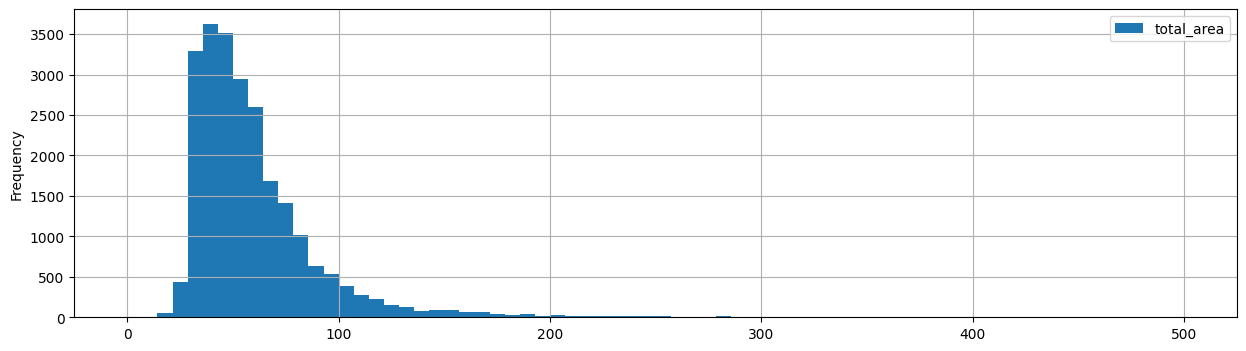

In [23]:
data.plot(y = 'total_area', kind = 'hist', bins = 70, grid=True, figsize = (15,4), range = (0,500));
data['total_area'].describe()

Квартиры больше 190м2 можно исключить, на анализ они не повлияют.

count    23385.000000
mean        57.933825
std         25.962455
min         12.000000
25%         40.000000
50%         51.700000
75%         68.600000
max        189.000000
Name: total_area, dtype: float64

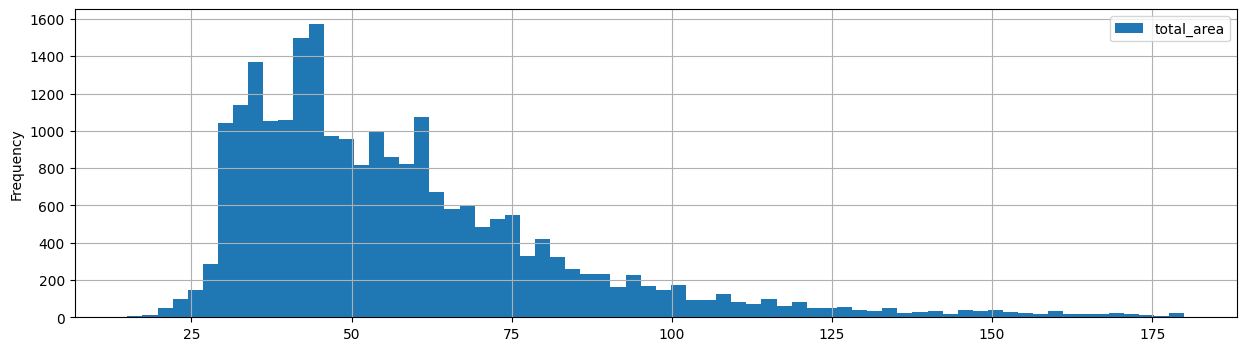

In [24]:
data = data[data['total_area'] < 190]
data.reset_index(drop= True , inplace= True)

data.plot(y = 'total_area', kind = 'hist', bins = 70, grid=True, figsize = (15,4), range = (15,180));
data['total_area'].describe()

***Вывод:*** <br>Из гистограммы видно, что основная масса квартир приходится скорее всего на 
"однушки" площадью 30-40 м2. Далее следуют квартиры с площадью 55-60 м2.

**Жилая площадь**

count    23385.000000
mean        33.164808
std         16.982881
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

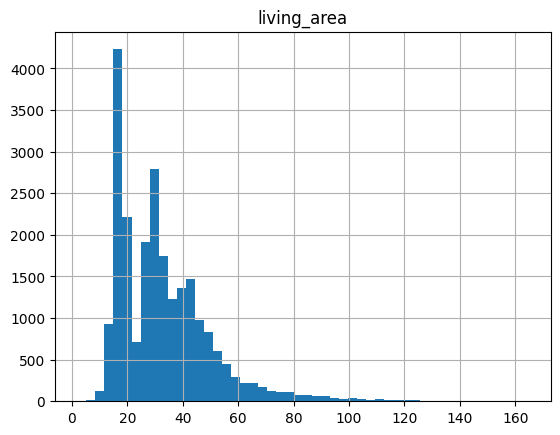

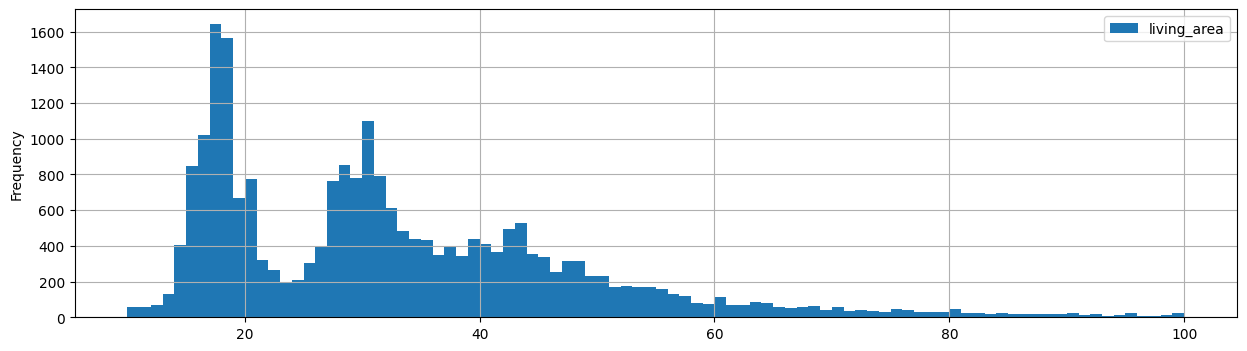

In [25]:
data.hist('living_area', bins=50);
data.plot(y = 'living_area', kind = 'hist', bins = 90, grid=True, figsize = (15,4), range = (10,100));
data['living_area'].describe()

***Вывод:*** <br>Основная выборка приходится на квартиры с жилой площадью 16-19 м2, далее 27-30 м2, и есть небольшой пик в районе 43-44 м2.

**Площадь кухни**

count    23385.000000
mean        10.263460
std          5.300743
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         93.200000
Name: kitchen_area, dtype: float64

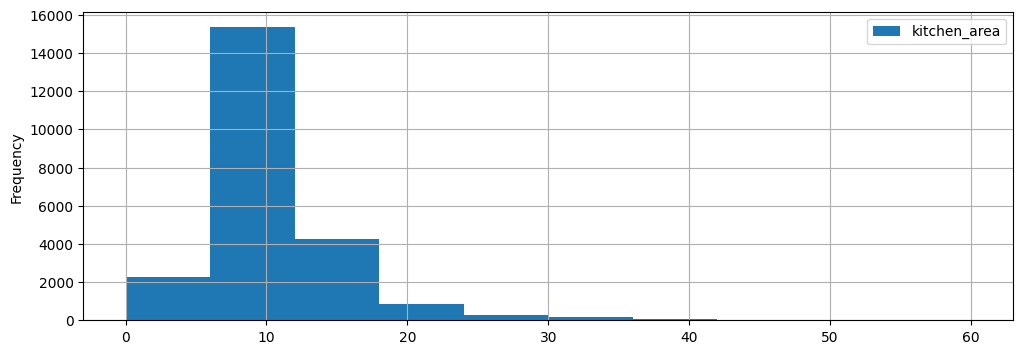

In [26]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 10, grid=True, figsize = (12,4), range = (0,60));
data['kitchen_area'].describe()

***Вывод:*** <br>В основном преобладают квартиры с кухнями площадью 7-12 м2.

**Цена объекта**

count    2.338500e+04
mean     5.977252e+06
std      5.766977e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.680000e+06
max      2.892384e+08
Name: last_price, dtype: float64

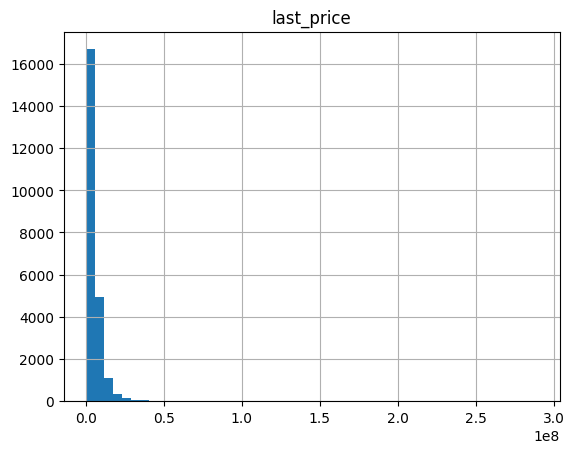

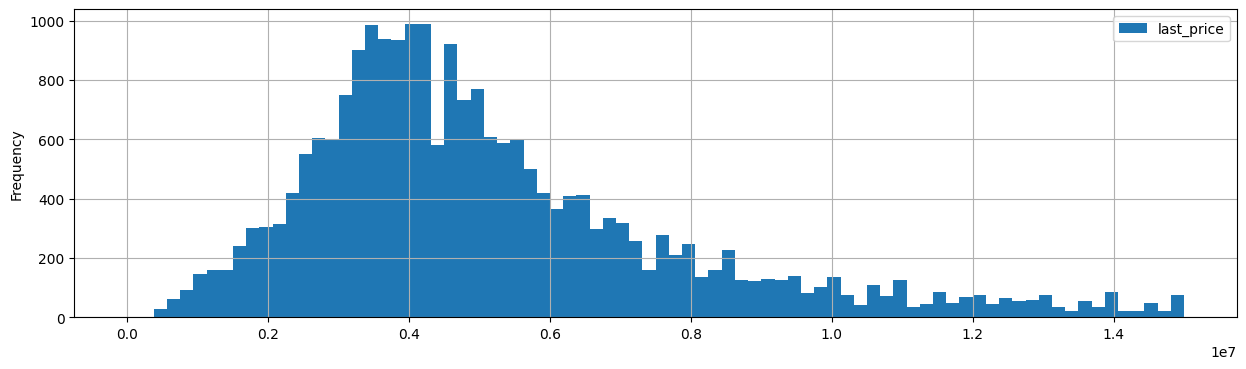

In [27]:
data.hist('last_price', bins=50);
data.plot(y = 'last_price', kind = 'hist', bins = 80, grid=True, figsize = (15,4), range = (0,15000000));
data['last_price'].describe()

***Вывод:*** <br>Из графика видно, что основная масса цен приходится на квартиры от 2,5 млн. до 6 млн. Пик приходится на 3,5 - 4 млн.

**Количество комнат**

In [28]:
data['rooms'].value_counts()

1     8034
2     7923
3     5778
4     1123
5      256
0      196
6       56
7       17
8        1
11       1
Name: rooms, dtype: int64

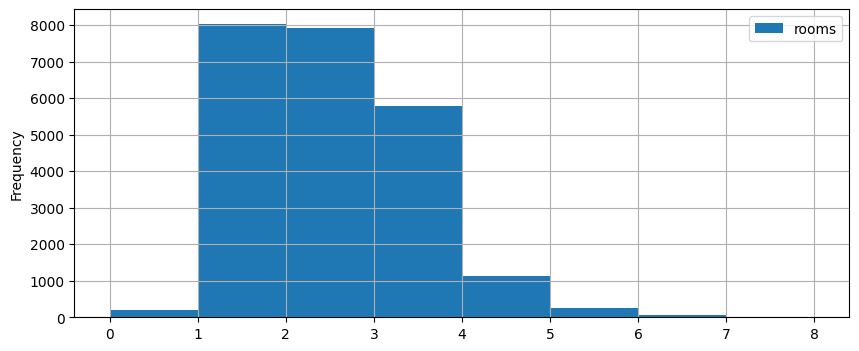

In [29]:
data.plot(y = 'rooms', kind = 'hist', bins = [0, 1, 2, 3, 4, 5, 6, 7, 8], grid=True, figsize = (10,4), range = (0,10));

Имеется 196 квартир с 0 комнатами. Скорее всего это квартиры студии, свободная планировка или апартаменты. Проверим.

In [30]:
print('Кол-во квартир/студий с 0 комнатами:', len(data.query('rooms == 0 and studio')), 'шт.')
print('Кол-во квартир со свободной планировкой с 0 комнатами:',len(data.query('rooms == 0 and open_plan')), 'шт.')
print('Кол-во апартаментов с 0 комнатами:',len(data.query('rooms == 0 and is_apartment')), 'шт.')

Кол-во квартир/студий с 0 комнатами: 138 шт.
Кол-во квартир со свободной планировкой с 0 комнатами: 58 шт.
Кол-во апартаментов с 0 комнатами: 0 шт.


Так оно и есть. С 0 комнатами это квартиры со свободной планировкой и студии. 

<br>***Вывод:*** <br>Из графика явно видно, что преимущественно на рынке востребованы 1 и 2-х комнатные квартиры. Количество друг от друга не сильно отличается. Отдадим им 1 место. На втором месте по популярности 3-х комнатные. Далее спрос на квартиры с большим количеством комнат резко падает.

**Высота потолков**

count    23385.000000
mean         2.718972
std          0.202760
min          2.200000
25%          2.600000
50%          2.720000
75%          2.720000
max          5.000000
Name: ceiling_height, dtype: float64

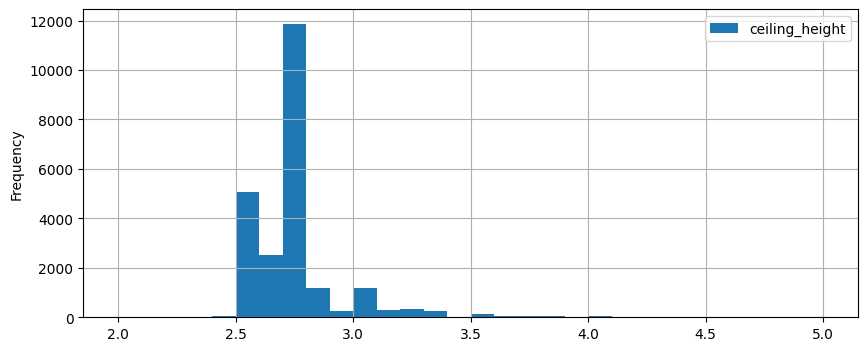

In [31]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, grid=True, figsize = (10,4), range = (2,5));
data['ceiling_height'].describe()

***Вывод:*** <br>Чаще всего встречаются квартиры с высотой от 2.5м до 3м. Пиковое значение 2.7м. Это и логично, стандартная высота. Выше 3-х метров уже встречаются реже, а ниже 2.5м и того меньше, единицы. 

**Этаж квартиры**

count    23385.000000
mean         5.904554
std          4.893376
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

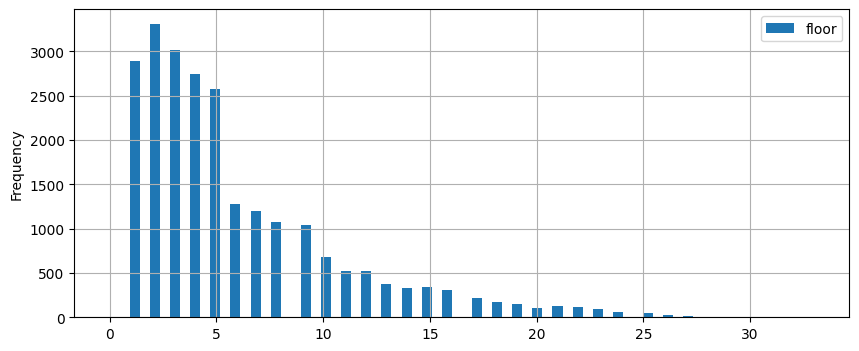

In [32]:
data.plot(y = 'floor', kind = 'hist', bins = 70, grid=True, figsize = (10,4), range = (0,33));
data['floor'].describe()

***Вывод:*** <br>Больше всего представлено квартир с 1 по 5 этажи, пик приходится на 2 этаж. С 6 по 9 этажи представлено в 3 раза меньше. 

**Тип этажа квартиры («первый», «последний», «другой»)**

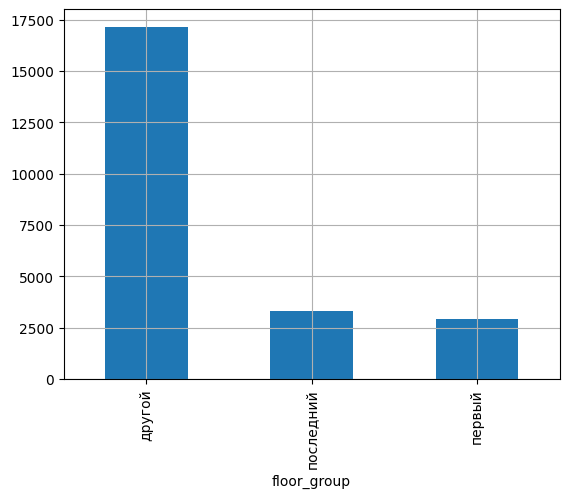

In [33]:
data.value_counts('floor_group').plot(y = 'floor_group', kind = 'bar', grid=True);

***Вывод:*** <br>Из столбчатой диаграммы видно, что больше всего предложений по типу этажа "другой". "Первый" и "последний" типы приблизительно равны.

**Общее количество этажей в доме**

count    23385.000000
mean        10.718238
std          6.602738
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

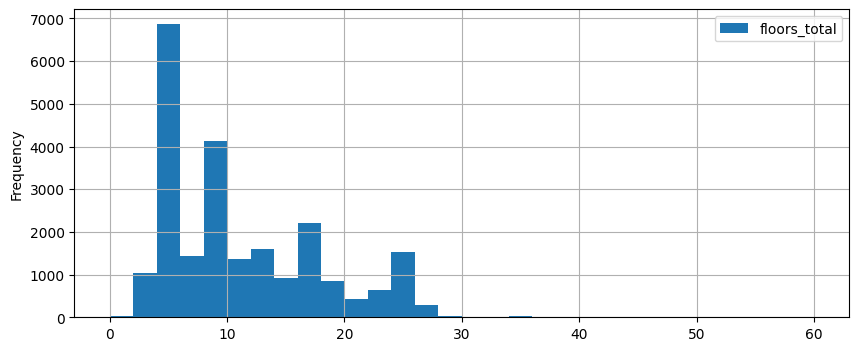

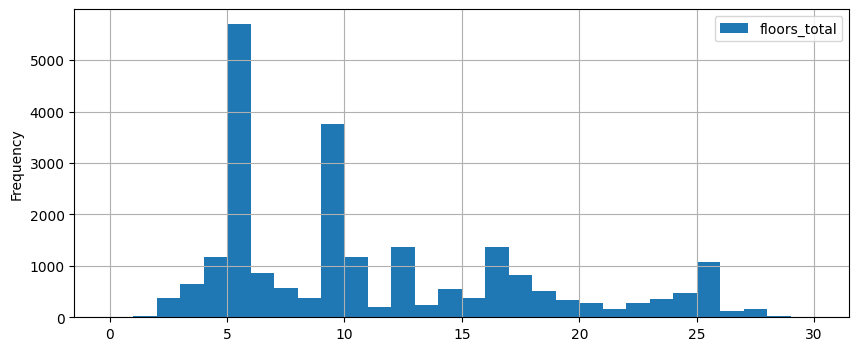

In [34]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, figsize = (10,4), range = (0,60));
data.plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, figsize = (10,4), range = (0,30));
data['floors_total'].describe()

***Вывод:*** <br>Больше всего предложений представлено в 5-и и 9-и этажных домах. А далее приблизительно равное предложение представлено в 4-х, 10-и, 12-и, 16-и и 26-и этажных домах.

**Расстояние до центра города в метрах**

count    17879.000000
mean     14299.584932
std       8588.345455
min        181.000000
25%       9461.500000
50%      13166.000000
75%      16333.000000
max      65968.000000
Name: citycenters_nearest, dtype: float64

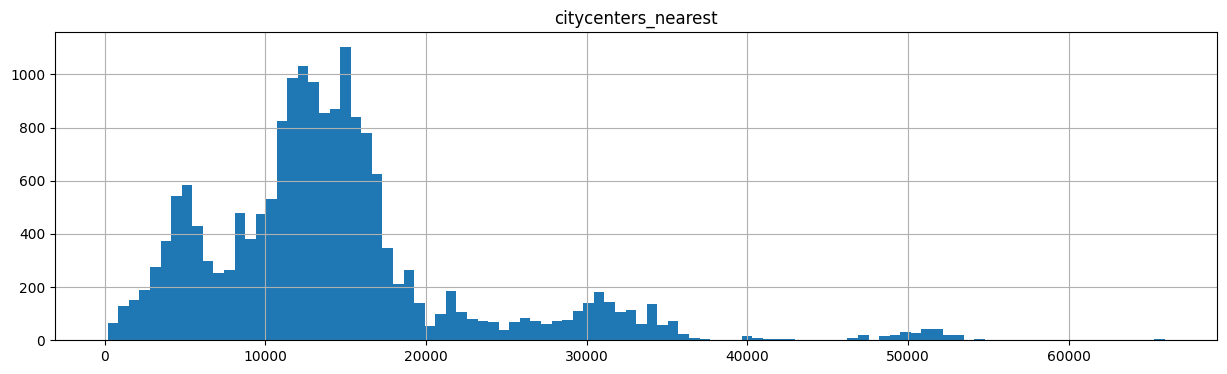

In [35]:
data.hist('citycenters_nearest', bins=100, figsize = (15,4));
data['citycenters_nearest'].describe()

***Вывод:*** <br>По графику видно 2 пиковых значения по расстоянию до центра города - 13 и 15 км, в 2 раза меньше предложений в 5 км, и есть небольшие пики в районе 21 и 30 км.

**Расстояние до ближайшего аэропорта**

count    17859.000000
mean     28835.555182
std      12688.576082
min          0.000000
25%      18499.000000
50%      26842.000000
75%      37407.000000
max      84869.000000
Name: airports_nearest, dtype: float64

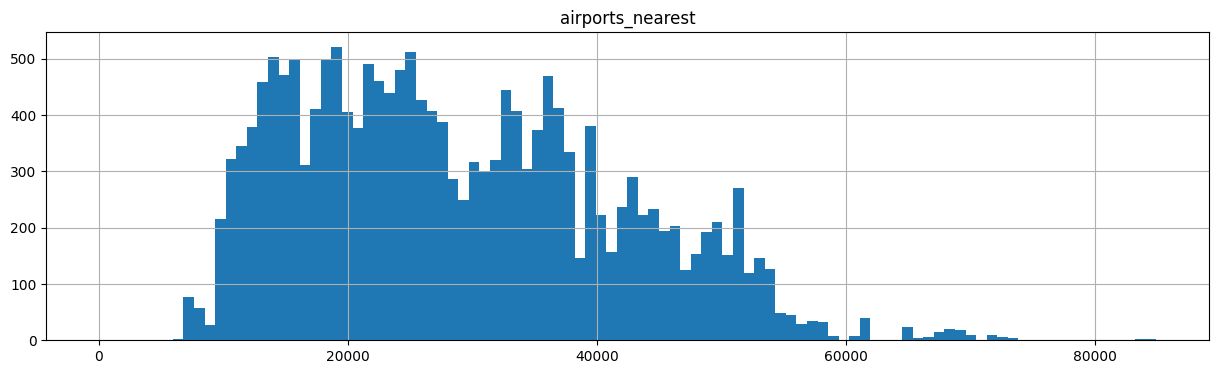

In [36]:
data.hist('airports_nearest', bins=100, figsize = (15,4));
data['airports_nearest'].describe()

Из графика видны аномалии расстояния до аэропорта жилой постройки равные 0. Проверим сколько таких аномалий и удалим их.

In [37]:
# Проверим сколько значений расстояния до ближайшего аэропорта меньше 5км
data[data['airports_nearest'] < 5000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_meter,day_week_ad_placement,month_ad_placement,year_ad_placement,floor_group,citycenters_nearest_km
20810,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,False,False,False,6.0,2,санкт-петербург,0.0,22801.0,0,NaN,0,NaN,60,201729,6,9,2018,другой,22


Только одно. Удалим эту строку.

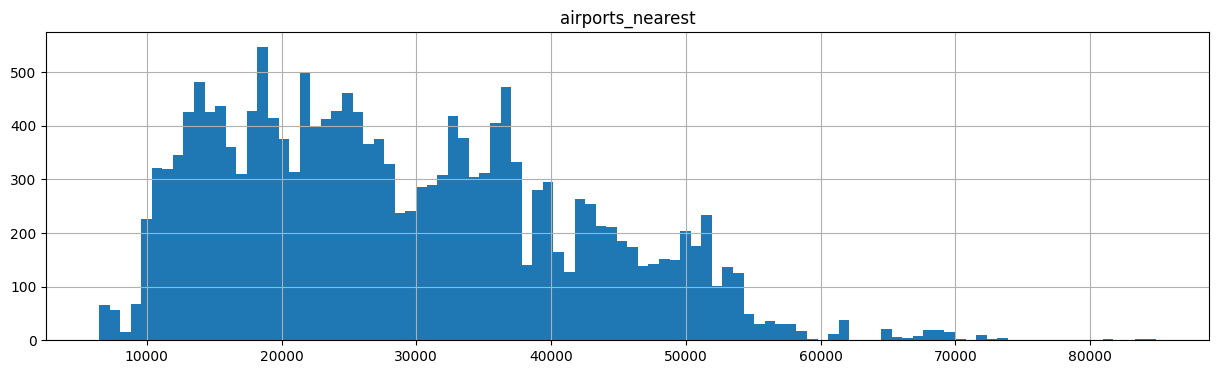

In [38]:
# Удалим эту строку по индексу и построим новый график.
data = data.drop(index=20810)
data.reset_index(drop= True , inplace= True)
data.hist('airports_nearest', bins=100, figsize = (15,4));

***Вывод:*** <br>По графику видны постоянные колебания в диапазоне от 10км до 52км удаленности от аэропорта.

**Расстояние до ближайшего парка**

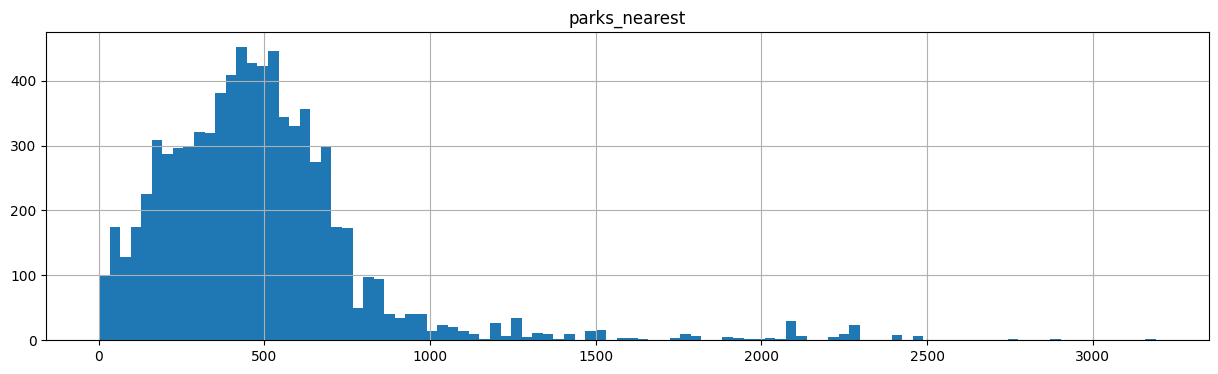

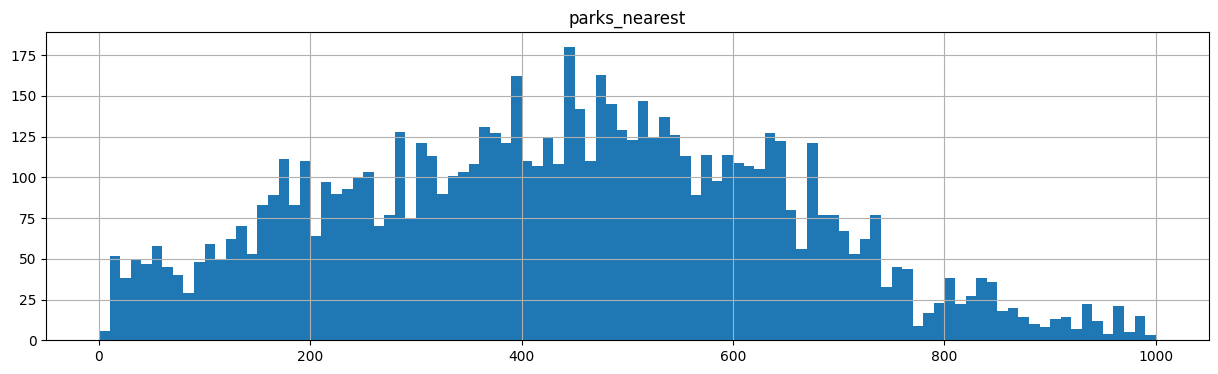

In [39]:
data.hist('parks_nearest', bins=100, figsize = (15,4));
data.hist('parks_nearest', bins=100, figsize = (15,4), range = (0,1000));

***Вывод:*** <br>Из графиков видно что больше всего квартир находится от парка в 770м. Пиковое значение приходится на 450м.

**Даты размещения (день недели, месяц, год)**

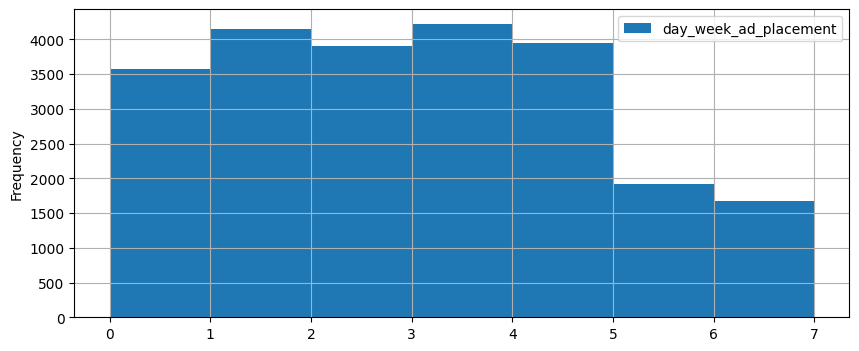

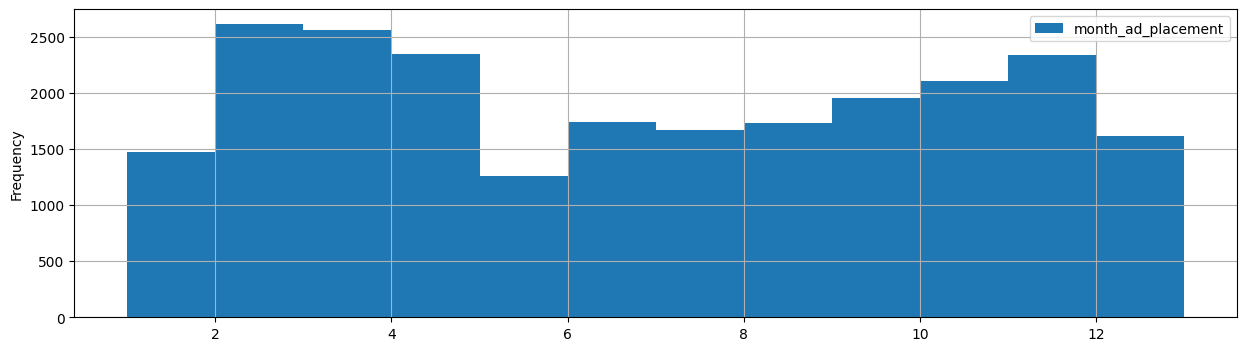

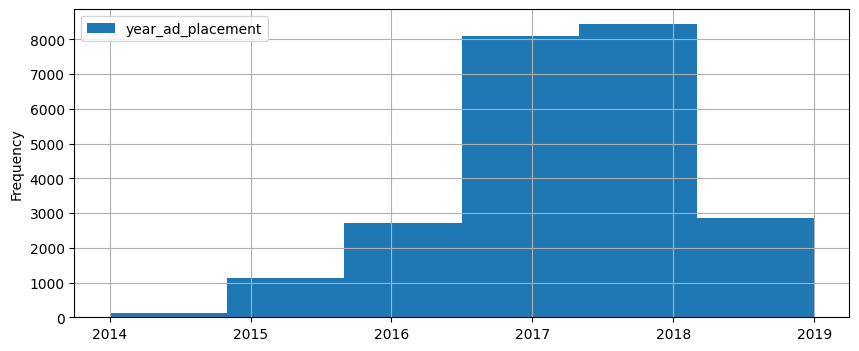

In [40]:
data.plot(y = 'day_week_ad_placement', kind = 'hist', bins = 7, grid=True, figsize = (10,4), range = (0,7));
data.plot(y = 'month_ad_placement', kind = 'hist', bins = 12, grid=True, figsize = (15,4), range = (1,13));
data.plot(y = 'year_ad_placement', kind = 'hist', bins = 6, grid=True, figsize = (10,4));

***Вывод:*** <br>Что мы видим из графиков касаемо публикаций объявлений:
- ****по дням недели:****
  - стабильная активность с понедельника по пятницу;
  - выходные провисает в 2 раза (оно и понятно);
- ****по месяцам:**** 
  - высокая активность с февраля по апрель и ноябрь;
  - январь и май провисают, особенно май (вероятно связано с длительными праздниками);
  - в летние месяцы активность на среднем уровне (сезон отпусков);
  - в сентябре и октябре подъем (окончание сезона отпусков);
  - декабрь - на среднем уровне (вероятно связано с подготовкой к новому году);
- ****по годам:****        
  - активное размещение в 2017-2018 годах;
  - 2015-2016 года - начало подьема после кризиса 2014 года;
  - 2019 год - резкий спад (вероятно связано со значительным повышением цен и, соответственно, падением спроса покупателей, а также изменений в ФЗ-214 по поводу перехода застройщиков на эскроу-счета);
  - 2014 год - учитывать не будем, есть предположение, что в таблице присутствуют данные только за пару месяцев.

#### Изучим, как быстро продавались квартиры (столбец days_exposition). 

count    20262.000000
mean       179.404600
std        218.266693
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

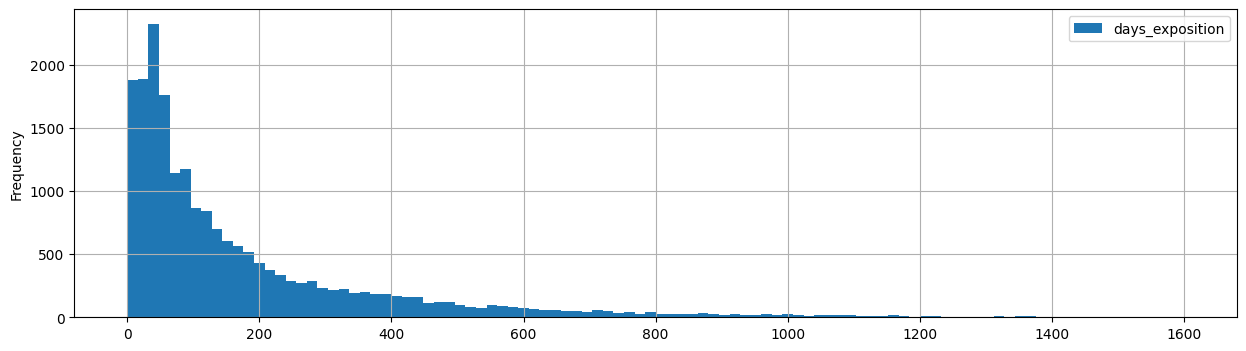

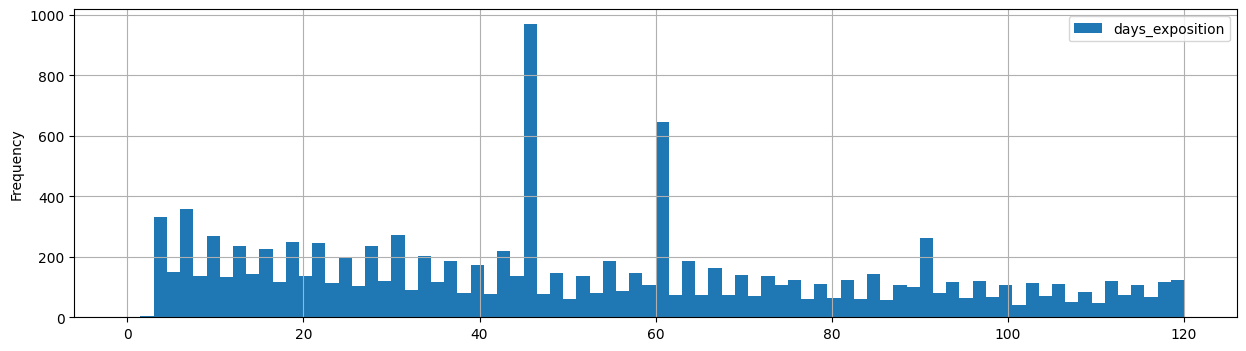

In [41]:
# Построим графики
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid=True, figsize = (15,4), range = (0,1600));
data.plot(y = 'days_exposition', kind = 'hist', bins = 80, grid=True, figsize = (15,4), range = (0,120));
data['days_exposition'].describe()

***Вывод:*** <br> Гистограмма скорости продажи квартир имеет распределение Пуассона.  <br> Медиану и среднее нашли методом `describe()`. Медиана равна __95__ дням, а среднее - __179__ дням. <br> На графике видим 2 всплеска: 45 и 60 дней. Похоже на выбросы, связанные с автоматическим снятием объявлений за их непродление или неоплату. Несмотря на эти всплески видно, что наибольшее количество продаж зафиксировано для 30 дней (больше всего пиков). Также видим пик в 90 дней. Скорее всего можно отнести к тем же выбросам, описанным выше.<br> Из проанализированных данных и графиков можно заключить следующее: 
* к быстрым продажам можно отнести продажи до __1 месяцев (до 31 дня)__;
* к долгим - продажи более __полугода (от 181 дня)__.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

__Изучим, зависит ли цена от:__
* общей площади;
* жилой площади;
* площади кухни;
* количества комнат;
* этажа, на котором расположена квартира (первый, последний, другой);
* даты размещения (день недели, месяц, год).
<br><br>Для этого построим графики и посчитаем корреляцию.

__Зависимость цены от общей, жилой и площади кухни__

Корелляция цены от площади: 0.686603916968657


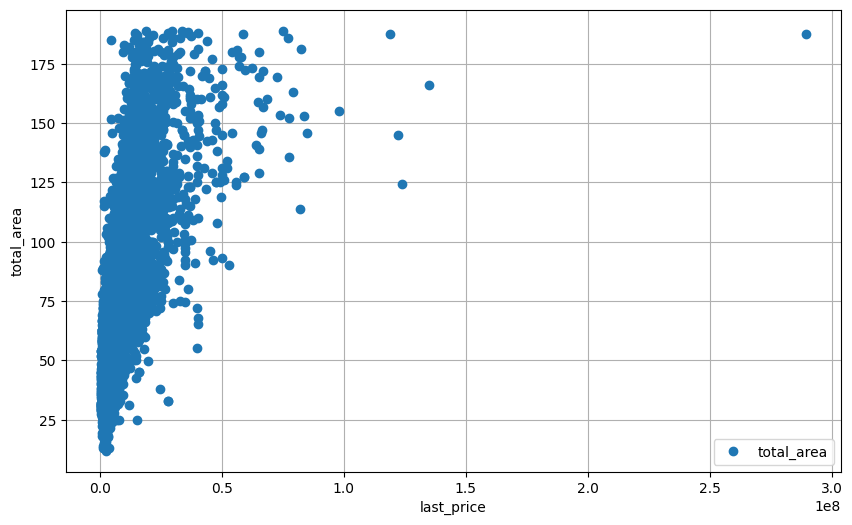

In [42]:
print('Корелляция цены от площади:', data['last_price'].corr(data['total_area']))
data.plot(x='last_price', y='total_area', ylabel='total_area', style = 'o', grid=True, figsize=(10, 6));

Из графика выдны выбивающиеся значения по цене. Поэтому, проверим количество квартир с ценой выше 20 млн.руб. и при малом количестве удалим их, т.к. они вляют на корреляцию.

Кол-во квартир с ценой более 20 млн.руб.: 498 шт.

Количество небольшое, на анализ не повлияет. 
Удалим эти строки и снова посмотрим корреляцию и построим график.

Корелляция цены от площади: 0.7737537197885396


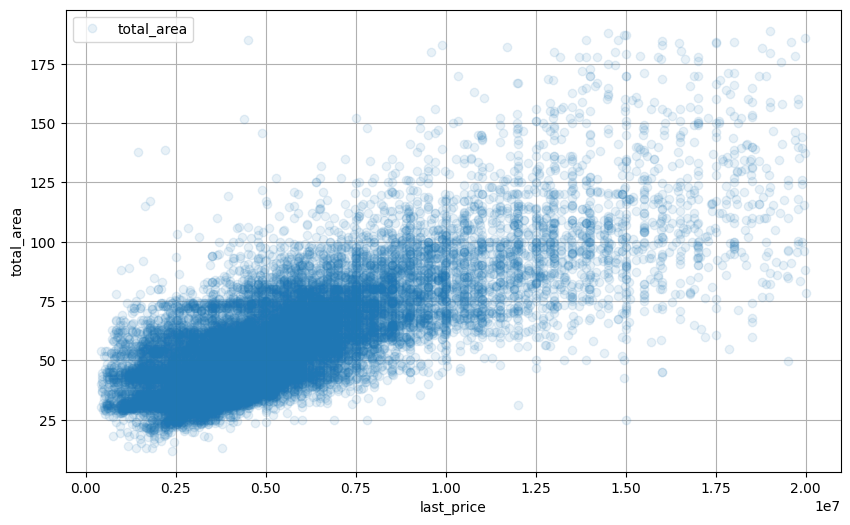

In [43]:
print('Кол-во квартир с ценой более 20 млн.руб.:', len(data[data['last_price'] > 20000000]), 'шт.')
print()
print('Количество небольшое, на анализ не повлияет. \nУдалим эти строки и снова посмотрим корреляцию и построим график.')
data = data[data['last_price'] < 20000000]
data.reset_index(drop= True , inplace= True)
print()
print('Корелляция цены от площади:', data['last_price'].corr(data['total_area']))
data.plot(x='last_price', y='total_area', ylabel='total_area', style = 'o', alpha=0.1, grid=True, figsize=(10, 6));

Корелляция цены от жилой площади: 0.6640001100849822


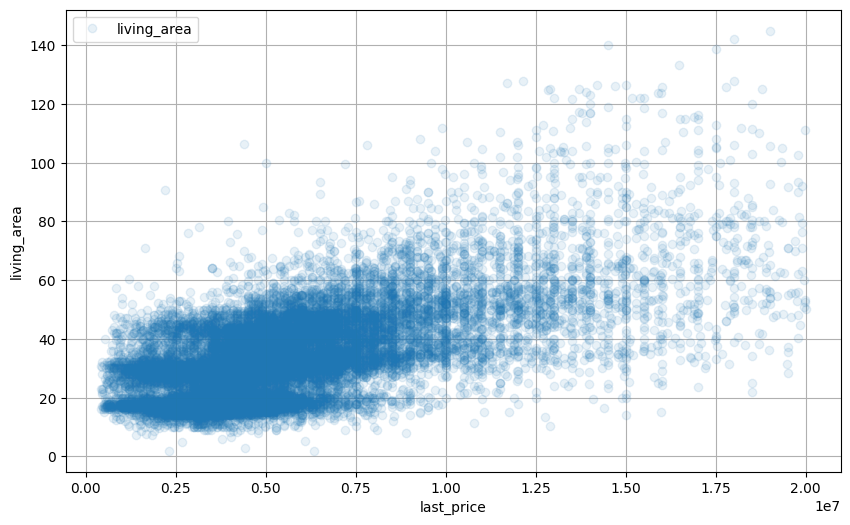

In [44]:
print('Корелляция цены от жилой площади:', data['last_price'].corr(data['living_area']))
data.plot(x='last_price', y='living_area', ylabel='living_area', style = 'o', alpha=0.1, grid=True, figsize=(10, 6));

Корелляция цены от площади кухни: 0.5927392330787036


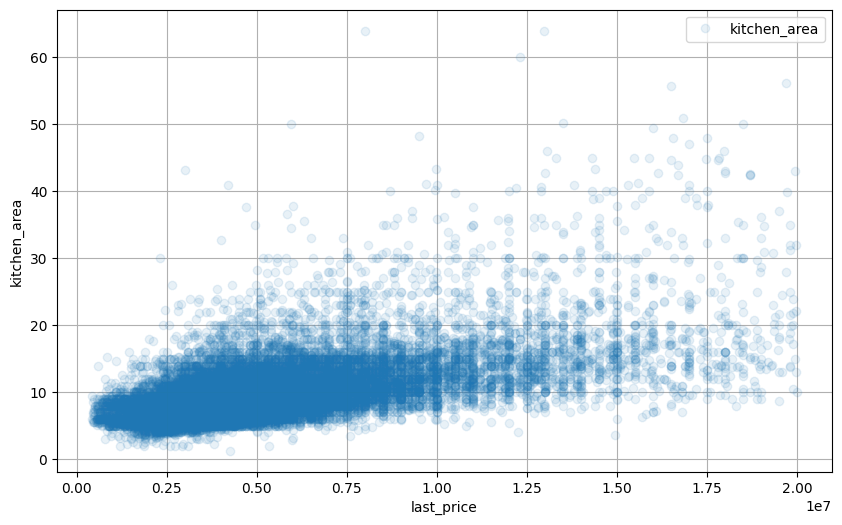

In [45]:
print('Корелляция цены от площади кухни:', data['last_price'].corr(data['kitchen_area']))
data.plot(x='last_price', y='kitchen_area', ylabel='kitchen_area', style = 'o', alpha=0.1, grid=True, figsize=(10, 6));

__Зависимость цены от количества комнат__

Корелляция цены от количества комнат: 0.5004095189994606


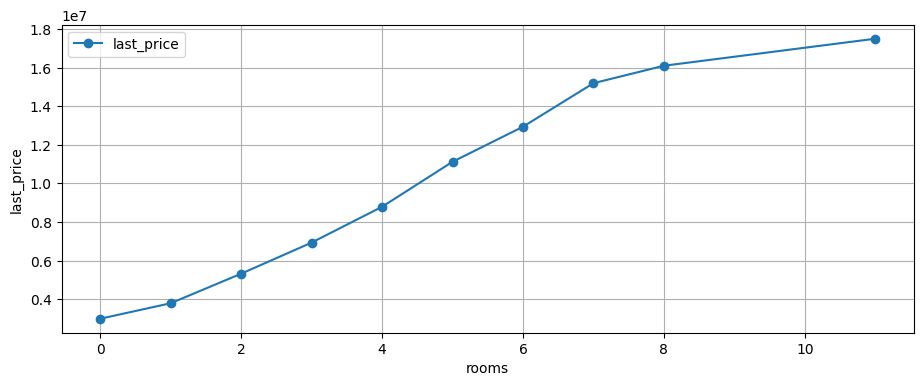

In [46]:
print('Корелляция цены от количества комнат:', data['last_price'].corr(data['rooms']))
(
    data.pivot_table(index='rooms', values='last_price')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(11, 4))
);

__Зависимость цены от этажа, на котором расположена квартира (первый, последний, другой)__

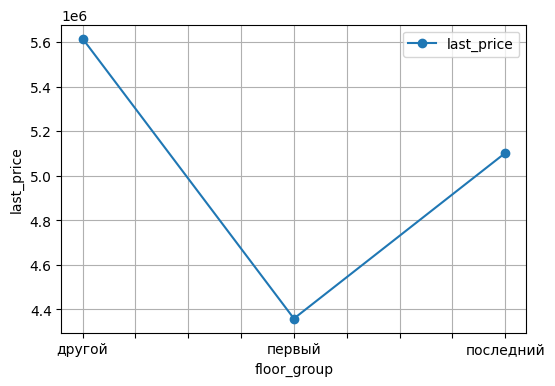

In [47]:
(
    data.pivot_table(index='floor_group', values='last_price')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(6, 4))
);


__Зависимость цены от даты размещения (день недели, месяц, год)__

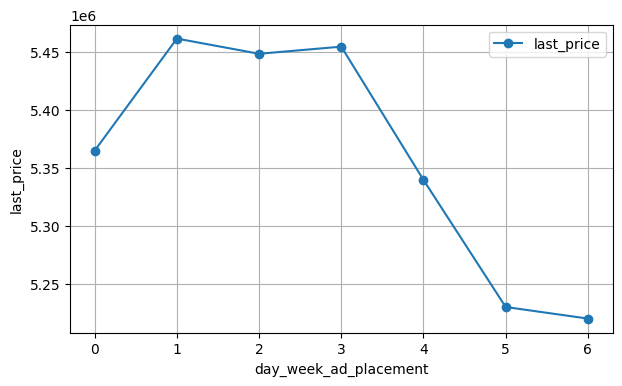

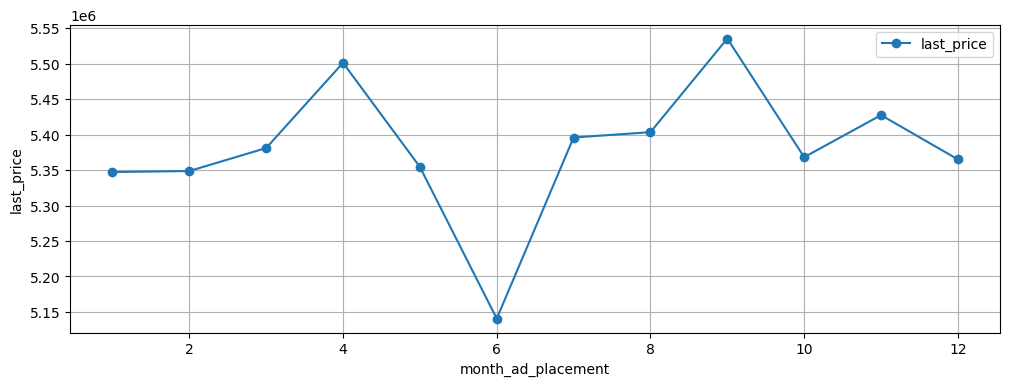

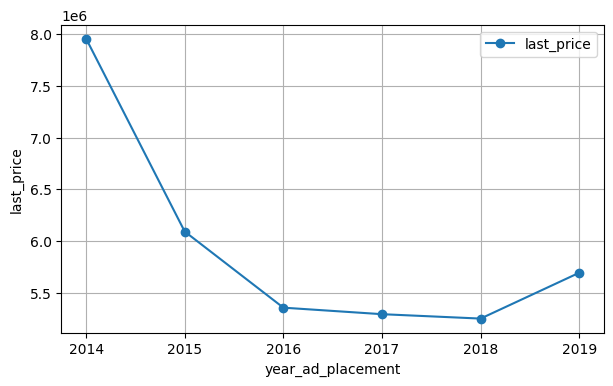

In [48]:
(
    data.pivot_table(index='day_week_ad_placement', values='last_price')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(7, 4))
);
(
    data.pivot_table(index='month_ad_placement', values='last_price')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(12, 4))
);
(
    data.pivot_table(index='year_ad_placement', values='last_price')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(7, 4))
);

***Вывод:*** <br> *Из проведенного анализа зависимости цены от факторов можно заключить следующее:*
<br>Видна большая зависимость от __площадей (общей, жилой и кухни)__. Чем больше площадь, тем больше и цена (оно и логично). Корреляция общей площади составляет __0,77__. Чуть меньше зависимость площади кухни и жилой, корреляция __0,59__ против __0,66__. 
<br>Прекрасно видна и зависимость цены от __количества комнат__. Чем больше комнат, тем больше цена. Оно и понятно, с увеличением количества комнат увеличивается и площадь квартиры.
<br>По __типу этажа__ - на __первые__ этажи самая низкая цена. Популярностью пользуются типы этажей __другие__, самая высокая. Цена на __последние__ этажи находится где-то по середине между __первыми__ и __другими__. 
<br>По __дате размещения__ также прослеживается зависимость: 
* по __дням недели__ - самые высокие цены со вторника по четверг, а самые низкие по выходным;
* по __месяцам__ - самые высокие в апреле и сентябре, низкие - в июне;
* по __годам__ - в 2014 году были самые высокие цены, далее цена резко падала до 2018 года (самые низкие цены), а в 2019 снова начали рости.

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [49]:
# Объявим новую переменную и сгруппируем сводную таблицу по названиям населенных пунктов, количеству объявлений 
# и средней цене 1 м2, в которой будут в том числе и 10 населенных пунктов с наибольшим числом объявлений
top10_locality_name = data.pivot_table(index='locality_name', values='price_one_meter', aggfunc=['count', 'mean'])

# Переименуем столбцы
top10_locality_name.columns = ['count', 'mean']

# Отсортируем по убыванию количества объявлений и выведем ТОП-10 населенных пунктов, а также
# переведем в целочисленный тип среднюю стоимость 1 м2 для удобства и выведем на экран таблицу
top10_locality_name = top10_locality_name.sort_values(by='count', ascending=False).head(10).astype(int)
top10_locality_name

,count,mean
locality_name,,
санкт-петербург,14971,108706
посёлок мурино,556,85681
посёлок шушары,440,78676
всеволожск,397,67213
пушкин,359,101867
колпино,337,75332
посёлок парголово,326,90331
гатчина,307,68745
деревня кудрово,299,92473


In [50]:
# Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра
print('Населённый пункт с самой высокой стоимостью квадратного метра:')
display(top10_locality_name[top10_locality_name['mean'] == top10_locality_name['mean'].max()])
print()
print('Населённый пункт с самой низкой стоимостью квадратного метра:')
top10_locality_name[top10_locality_name['mean'] == top10_locality_name['mean'].min()]

Населённый пункт с самой высокой стоимостью квадратного метра:


,count,mean
locality_name,,
санкт-петербург,14971,108706



Населённый пункт с самой низкой стоимостью квадратного метра:


,count,mean
locality_name,,
выборг,237,58141


***Вывод:*** <br> Из ТОП-10 населённых пунктов с наибольшим числом объявлений самая высокая стоимость одного квадратного метра в городе __Санкт-Петербург__ (__108 706,00 руб.__), а самая низкая в городе __Выборг__ (__58 141,00 руб.__).

#### Выделим квартиры в Санкт-Петербурге, вычислим среднюю цену каждого километра и опишем, как стоимость объектов зависит от расстояния до центра города.

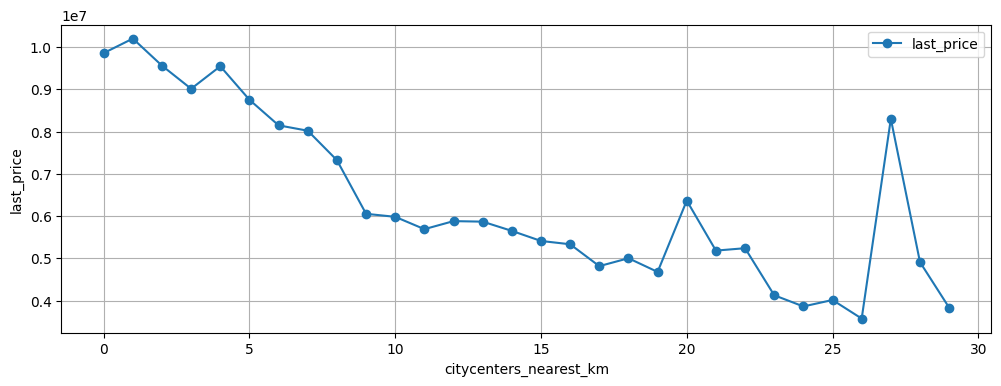

In [51]:
# Сделаем выборку таблицы по г.Санкт-петербург, сгрупприруем сводную таблицу 
# по расстоянию до центра в километрах и средней цене, и построим график
(
    data[data['locality_name'] == 'санкт-петербург']
    .pivot_table(index='citycenters_nearest_km', values='last_price', aggfunc='mean')
    .plot(y='last_price', ylabel='last_price', style='o-', grid=True, figsize=(12, 4))
);

***Вывод:*** <br> 
Пиковое значение цены квартир приходится на расстоянии в 1 км до центра города.
<br> На расстоянии от 0 до 4 км показатели цен +- одинаковые. Выбивается только цена квартир до 3-х км, но не сильно.
<br> С 5-и км цены резко начинают снижаться. Здесь, видимо, заканчивается центр города.
<br> Незначительный подъем возникает на расстояниях в 12 и 13 км. Возможно новостройки или престижный район.
<br> На расстояния 20 и 27 км видим существенные скачки, особенно на расстоянии 27 км (цены практически сопоставимы ценам 5-и км). Скорее всего там находится элитная недвижимость в престижном районе.

### Общий вывод

Мы открыли и изучили данные в таблице. __Провели__ необходимую __предобработку__ столбцов: заполнили пропуски, поменяли типы данных, изучили уникальные значения, устранили дубликаты, нашли и устранили редкие и выбивающиеся значения.
<br>Для дальнейшего исследования __добавили ряд столбцов__ с ценой 1 м2, днём недели, месяцем и годом публикации объявления, типом этажа и расстоянием до центра города в километрах.
<br>После обработки данных __провели исследовательский анализ__.
Построили ряд графиков, на основании которых можно сделать вывод, __какие квартиры интересны покупателям__. 
<br>Это:
- 1-2-х комнатные квартиры 
- общей площадью 30-40 м2 
- жилой площадью 16-19 м2 
- площадью кухон 7-12 м2
- с высотой потолков от 2.5 до 3 м
- расположенных со 2 по 9 этаж
- в 5-и и 9-и этажных домах
- по цене от 2,5 млн. до 6 млн. руб.
- находящихся на расстоянии 13-15 км до центра города
- до 770 м удаленности от парка 
- в 10-52 км удаленности от аэропорта.

<br>Также, на основании графиков выяснили, что чаще всего __публикация объявлений__ проходила в 2017-2018 годах, февраль, март, апрель и ноябрь, с понедельника по пятницу.
<br>
<br>На основании гистограммы выявили __скорость продажи__ квартир. К быстрым продажам отнесли продажи до 1 месяцев (до 31 дня), а к долгим - продажи более полугода (от 181 дня).
<br>
<br>Выяснили __зависимость цены от факторов__.
* Большая __зависимость от площадей (общей, жилой и кухни)__. Чем больше площадь, тем больше и цена. 
* Такая же __зависимость и от количества комнат__. Чем больше комнат, тем больше цена. 
* По __типу этажа__ популярностью пользуются любые этажи, кроме первого и последнего (самая высокая цена). Нишу с самыми низкими ценами заняли первые этажи.
* По __дате размещения__:
  * высокие цены __по дням недели__ со вторника по четверг, а самые низкие по выходным;
  * __по месяцам__ - высокие в апреле и сентябре, низкие - в июне;
  * __по годам__ - в 2014 году были самые высокие цены, а самые низкие 2018 года.

<br>Выявили __ТОП-10 населённых пунктов с наибольшим числом объявлений, где самая высокая стоимость 1 м2__. Среди них все крупные города Ленинградской области: Всеволожск, Пушкин, Колпино, Гатчина, Выборг. Кстати, в Выборге самая низкая стоимость 1 м2 - 58 141,00 руб. А самая высокая в Санкт-Петербурге - 108 706,00 руб. Оно и понятно, ему же принадлежит первое место в ТОП-10. Также __в Санкт-Петербурге самая дорогая недвижимость от центра города__ находится в радиусе от 0 до 5 км. А в 27 км до центра представлена недвижимость, цены на которую практически сопоставимы с ценами 5-и км от центра города. Скорее всего элитное жилье.   